# 02 – Sanity Checks (Library Borrowings)

**Purpose:** Validate internal consistency and plausibility of the merged borrowing dataset before any analysis.

This notebook:
- parses key fields (timestamps, numeric columns),
- runs consistency checks (dates, durations, lateness, identifiers),
- summarizes the number and share of affected records.

**Not included:**
- no filtering, no dropping rows,
- no interpretation of causes.

Cleaning decisions will be made in the next notebook (`03_data_cleaning.ipynb`).

In [ ]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
DATA_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025.csv" 


In [2]:
# --- load data ---
borrowings = pd.read_csv(
    DATA_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2407610, 17)


In [3]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"
RETURN_COL = "Rückgabedatum/Uhrzeit"

DURATION_COL = "Leihdauer"
EXT_COL = "Anzahl_Verlängerungen"
LATE_FLAG_COL = "Verspätet"
LATE_DAYS_COL = "Tage_zu_spät"

ID_COL = "issue_id"
USER_COL = "Benutzer-Systemnummer"
BARCODE_COL = "Barcode"

# timestamps
for c in [ISSUE_COL, RETURN_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_datetime(borrowings[c], errors="coerce")

# numeric columns
for c in [DURATION_COL, EXT_COL, LATE_DAYS_COL]:
    if c in borrowings.columns:
        borrowings[c] = pd.to_numeric(borrowings[c], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")


The following function is a helper for logging upcoming issues in the sanity checking process.

In [4]:
# --- define issue logging function ---
issues = []

def log_issue(name: str, mask: pd.Series):
    mask = mask.fillna(False) # mask is a bool: True for affected rows
    n = int(mask.sum())
    pct = (n / len(borrowings)) * 100 if len(borrowings) else 0.0
    issues.append({"check": name, "affected_rows": n, "affected_pct": pct})

## A) Timestamp sanity checks

In [5]:
#-- perform sanity checks on timestamps ---

# missing timestamps
if ISSUE_COL in borrowings.columns:
    log_issue("missing_issue_timestamp", borrowings[ISSUE_COL].isna())

if RETURN_COL in borrowings.columns:
    log_issue("missing_return_timestamp", borrowings[RETURN_COL].isna())

# return before issue
if {ISSUE_COL, RETURN_COL}.issubset(borrowings.columns):
    log_issue("return_before_issue", borrowings[RETURN_COL] < borrowings[ISSUE_COL])

## B) Duration consistency

In [6]:
# --- perform sanity checks on durations ---

if DURATION_COL in borrowings.columns:
    log_issue("missing_durration_timestamp", borrowings[DURATION_COL].isna())

# compute duration from timestamps (days)
if {ISSUE_COL, RETURN_COL}.issubset(borrowings.columns):
    borrowings["duration_from_ts_days"] = (borrowings[RETURN_COL] - borrowings[ISSUE_COL]).dt.days

# negative or extreme durations (from provided column)
if DURATION_COL in borrowings.columns:
    log_issue("negative_Leihdauer", borrowings[DURATION_COL] < 0)
    log_issue("Leihdauer_gt_365", borrowings[DURATION_COL] > 365)

# Todo: maybe this is not needed because of the previous check?
# borrowing duration vs. extensions consistency
if "duration_from_ts_days" in borrowings.columns:
    log_issue("duration_from_ts_gt_365", borrowings["duration_from_ts_days"] > 365)
    log_issue("duration_from_ts_negative", borrowings["duration_from_ts_days"] < 0)

# mismatch between provided duration and computed duration
if {DURATION_COL, "duration_from_ts_days"}.issubset(borrowings.columns):
    diff = (borrowings[DURATION_COL] - borrowings["duration_from_ts_days"]).abs()
    log_issue("Leihdauer_mismatch_abs_gt_1day", diff > 1)

## C) Lateness consistency

In [7]:
# --- perform sanity checks on extensions ---

# late days plausibility
if LATE_DAYS_COL in borrowings.columns:
    log_issue("negative_Tage_zu_spaet", borrowings[LATE_DAYS_COL] < 0)
    log_issue("Tage_zu_spaet_gt_365", borrowings[LATE_DAYS_COL] > 365)

# consistency between Verspätet and Tage_zu_spät
if {"late_bool", LATE_DAYS_COL}.issubset(borrowings.columns):
    log_issue("late_bool_FALSE_but_Tage_zu_spaet_gt_0", (borrowings["late_bool"] == False) & (borrowings[LATE_DAYS_COL] > 0))
    log_issue("late_bool_TRUE_but_Tage_zu_spaet_eq_0_or_missing", (borrowings["late_bool"] == True) & ((borrowings[LATE_DAYS_COL].isna()) | (borrowings[LATE_DAYS_COL] <= 0)))

if EXT_COL in borrowings.columns:
    log_issue("negative_extensions", borrowings[EXT_COL] < 0)
    log_issue("extensions_gt_20", borrowings[EXT_COL] > 20)  # Todo: 20 is maybe still to large?


## D) Identifier Checks

In [8]:
# missing identifiers
if ID_COL in borrowings.columns:
    log_issue("missing_issue_id", borrowings[ID_COL].isna())

if USER_COL in borrowings.columns:
    log_issue("missing_user_id", borrowings[USER_COL].isna())

if BARCODE_COL in borrowings.columns:
    log_issue("missing_barcode", borrowings[BARCODE_COL].isna())

# duplicates (if column exists)
if ID_COL in borrowings.columns:
    log_issue("duplicate_issue_id", borrowings[ID_COL].duplicated(keep=False))

## Result

,check,affected_rows,affected_pct
0,missing_barcode,417251,17.3305
1,missing_user_id,163306,6.7829
2,missing_durration_timestamp,48786,2.0263
3,missing_return_timestamp,48786,2.0263
4,Leihdauer_gt_365,1678,0.0697
5,duration_from_ts_gt_365,1662,0.0690
6,extensions_gt_20,115,0.0048
7,Tage_zu_spaet_gt_365,97,0.0040
8,missing_issue_timestamp,0,0.0000
9,late_bool_TRUE_but_Tage_zu_spaet_eq_0_or_missing,0,0.0000


Total rows: 2407610
Checks run: 19


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_73353/628945082.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


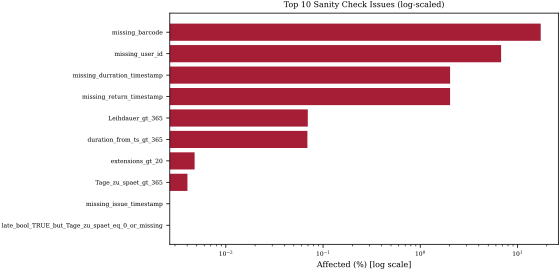

In [9]:
# --- summarize issues ---

# table of issues
issues_df = pd.DataFrame(issues).sort_values("affected_rows", ascending=False).reset_index(drop=True)
display(issues_df)

print("Total rows:", len(borrowings))
print("Checks run:", len(issues_df))

# plot top 10 issues
top = issues_df.head(10).iloc[::-1]

plt.figure(figsize=(8, 4))
plt.barh(top["check"], top["affected_pct"])
plt.xscale("log")
plt.xlabel("Affected (%) [log scale]")
plt.title("Top 10 Sanity Check Issues (log-scaled)")
plt.tight_layout()
plt.show()



## Sanity Check Summary

- Number of checks performed: **19**
- Most frequent issues: **missing_barcode (17.33%); missing_user_id (6,7%); missing_return_timestemp; Leihdauer_gt_365**
- Next step: cleaning rules in `03_data_cleaning.ipynb` based on these findings.


## F) Special Sanity Checks

This section provides a deeper analysis of data quality beyond the basic checks, focusing on:
- Detailed examination of loan durations, including recalculations from timestamps and comparisons with provided values.
- Identification of edge cases, such as same-day borrows/returns, identical timestamps, or negative time differences.
- Analysis of duplicate timestamps and potential data entry errors or system behaviors.

In [10]:
# --- special sanity checks: loan durations and edge cases ---

# Zurückgegebene Ausleihen
complete_mask = borrowings[ISSUE_COL].notna() & borrowings[RETURN_COL].notna()

# Berechne Leihdauer neu (in Tagen)
borrowings.loc[complete_mask, 'Leihdauer_neu'] = np.round(
    (borrowings.loc[complete_mask, RETURN_COL] - borrowings.loc[complete_mask, ISSUE_COL]).dt.total_seconds() / 86400
).astype(int)

# Vergleich mit original Leihdauer
borrowings['Leihdauer_num'] = pd.to_numeric(borrowings[DURATION_COL], errors='coerce')
compare_mask = complete_mask & borrowings['Leihdauer_num'].notna()

borrowings.loc[compare_mask, 'Diff_in_Tagen'] = borrowings.loc[compare_mask, 'Leihdauer_neu'] - borrowings.loc[compare_mask, 'Leihdauer_num']

# Zählungen
pos = (borrowings['Diff_in_Tagen'] > 0).sum()
neg = (borrowings['Diff_in_Tagen'] < 0).sum()
zero = (borrowings['Diff_in_Tagen'] == 0).sum()

# Edge Cases
delta_raw = borrowings.loc[complete_mask, RETURN_COL] - borrowings.loc[complete_mask, ISSUE_COL]
zero_day = (delta_raw.dt.days == 0).sum()
zero_exact_ts = (delta_raw.dt.total_seconds() == 0).sum()

# Negative Zeitdifferenzen
negative_mask = delta_raw.dt.total_seconds() < 0
negative_count = negative_mask.sum()

# Verteilung der Differenzen
if compare_mask.sum() > 0:
    diff_counts = borrowings.loc[compare_mask, 'Diff_in_Tagen'].value_counts().sort_index()
    diff_summary = (
        diff_counts.head(10).rename('Anzahl')
        .to_frame()
        .assign(Anteil=lambda x: x['Anzahl'] / compare_mask.sum())
        .reset_index()
        .rename(columns={'index': 'Differenz (berechnet - Original)'})
    )

# Beispiele für negative Fälle
if negative_count > 0:
    neg_examples = borrowings.loc[complete_mask].loc[negative_mask, [
        ISSUE_COL, RETURN_COL, 'Leihdauer_num', 'Leihdauer_neu', 'Diff_in_Tagen'
    ]].head(5)

# --- results ---
print("\n=== Comparison: CSV borrow duration vs. calculated borrow duration ===")
print(f"Comparable cases: {compare_mask.sum()}")
print(f" - Calculated longer: {pos} ({(pos/max(compare_mask.sum(),1)):.2%})")
print(f" - Both equal: {zero} ({(zero/max(compare_mask.sum(),1)):.2%})")
print(f" - Calculated shorter: {neg} ({(neg/max(compare_mask.sum(),1)):.2%})")

# Verteilung der Differenzen
if compare_mask.sum() > 0:
    print("\n=== Top 10 Differences ===")
    display(diff_summary.style.format({'Anteil': '{:.2%}'}))

print("\n=== Edge Cases ===")
print(f"Same day borrow and returns (different times): {zero_day}")
print(f"Exactly identical timestamps: {zero_exact_ts}")
print(f"Negative time differences (data errors): {negative_count}")

# Beispiele für negative Fälle
if negative_count > 0:
    print("\n=== Examples of Negative Cases ===")
    display(neg_examples)


=== Comparison: CSV borrow duration vs. calculated borrow duration ===
Comparable cases: 2358824
 - Calculated longer: 195 (0.01%)
 - Both equal: 2357887 (99.96%)
 - Calculated shorter: 742 (0.03%)

=== Top 10 Differences ===


,Diff_in_Tagen,Anzahl,Anteil
0,-1.000000,742,0.03%
1,0.000000,2357887,99.96%
2,1.000000,195,0.01%



=== Edge Cases ===
Same day borrow and returns (different times): 45638
Exactly identical timestamps: 0
Negative time differences (data errors): 0


### Duplicate and Timestamp Analysis

Additional checks for duplicate rows, identical timestamps, and group analyses to identify potential data entry errors or system behaviors.

In [11]:
# --- duplicate and timestamp analysis ---

# Komplett identische Zeilen
duplicate_count = borrowings.duplicated().sum()

# Identische Ausleih- und Rückgabezeiten
exact_timestamp_duplicates = borrowings.duplicated(subset=[ISSUE_COL, RETURN_COL])
exact_timestamp_count = exact_timestamp_duplicates.sum()

# Identische Zeitstempel + gleicher Benutzer
exact_user_timestamp_duplicates = borrowings.duplicated(
    subset=[ISSUE_COL, RETURN_COL, USER_COL]
)
exact_user_timestamp_count = exact_user_timestamp_duplicates.sum()

# Identische Zeitstempel aber verschiedene Benutzer
timestamp_user_stats = borrowings.groupby([ISSUE_COL, RETURN_COL]).agg({
    USER_COL: 'nunique'
}).rename(columns={USER_COL: 'unique_users'})

multi_user_timestamps = (timestamp_user_stats['unique_users'] > 1).sum()

# Gleiche Ausleihe-Zeit (ohne Rückgabe) aber verschiedene Benutzer
issue_time_stats = borrowings.groupby(ISSUE_COL).agg({
    USER_COL: 'nunique'
}).rename(columns={USER_COL: 'unique_users'})

multi_user_issue_times = issue_time_stats[issue_time_stats['unique_users'] > 1]

# Gemeinsame Ausleihe-Zeit + gleicher Benutzer aber mehrere Medien
same_user_same_time = borrowings.groupby([ISSUE_COL, USER_COL]).size()
multi_item_checkouts = (same_user_same_time > 1).sum()
max_simultaneous = same_user_same_time.max() if multi_item_checkouts > 0 else 0

# Analyse der Gruppen mit gleichen Timestamps
timestamp_groups = borrowings.groupby([ISSUE_COL, RETURN_COL]).size()
groups_with_duplicates = timestamp_groups[timestamp_groups > 1]

multi_user_groups = timestamp_user_stats[timestamp_user_stats['unique_users'] > 1]

# --- results ---
print("\n=== Duplicate Rows Check ===")
print(f"Number of complete duplicate rows: {duplicate_count}")
print(f"Rows with identical borrow and return timestamps: {exact_timestamp_count}")
print(f"Rows with identical borrow and return timestamps and same user: {exact_user_timestamp_count}")

if exact_user_timestamp_count > 0:
    print("\nExamples (same user, same timestamps):")
    duplicates = borrowings[borrowings.duplicated(subset=[ISSUE_COL, RETURN_COL, USER_COL], keep=False)]
    display(duplicates.sort_values([ISSUE_COL, RETURN_COL, USER_COL])[[ISSUE_COL, RETURN_COL, USER_COL]].head(10))

print(f"\nSame borrow and return timestamps with different user: {multi_user_timestamps}")
print(f"Same borrow times with different users (different return times): {len(multi_user_issue_times)}")

print(f"\nCases where one user borrowed multiple items at exact same time: {multi_item_checkouts}")
if multi_item_checkouts > 0:
    print(f"Maximum items borrowed simultaneously by one user: {max_simultaneous}")


=== Duplicate Rows Check ===
Number of complete duplicate rows: 0
Rows with identical borrow and return timestamps: 12016
Rows with identical borrow and return timestamps and same user: 11573

Examples (same user, same timestamps):


,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Benutzer-Systemnummer
41188,2019-02-28 15:51:14,2019-04-18 12:07:41,"10,053.0000"
41190,2019-02-28 15:51:14,2019-04-18 12:07:41,"10,053.0000"
48097,2019-03-06 11:52:29,2019-06-13 16:30:16,"27,280.0000"
48098,2019-03-06 11:52:29,2019-06-13 16:30:16,"27,280.0000"
63088,2019-03-16 13:34:58,2019-05-07 17:12:02,NaN
63089,2019-03-16 13:34:58,2019-05-07 17:12:02,NaN
89512,2019-04-10 10:44:42,2019-05-22 16:33:04,"28,306.0000"
89513,2019-04-10 10:44:42,2019-05-22 16:33:04,"28,306.0000"
89514,2019-04-10 10:44:42,2019-05-22 16:33:04,"28,306.0000"
89515,2019-04-10 10:44:42,2019-05-22 16:33:04,"28,306.0000"



Same borrow and return timestamps with different user: 1
Same borrow times with different users (different return times): 37790

Cases where one user borrowed multiple items at exact same time: 277635
Maximum items borrowed simultaneously by one user: 7
